In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [31]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [32]:
class DNN_2(nn.Module):
    def __init__(self, input_dim,hidden_units1,hidden_units2,hidden_units3,hidden_units4,dropout1,dropout2,dropout3,dropout4):
        super(DNN_2, self).__init__()
        self.layer1 = nn.Linear(input_dim,hidden_units1)
        self.layer2 = nn.Linear(hidden_units1,hidden_units2)
        self.layer3 = nn.Linear(hidden_units2, hidden_units3)
        self.layer4 = nn.Linear(hidden_units3, hidden_units4)
        self.output_layer = nn.Linear(hidden_units4, 1)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.dropout3 = nn.Dropout(dropout3)
        self.dropout4 = nn.Dropout(dropout4)


        self.bn1 = nn.BatchNorm1d(hidden_units1)
        self.bn2 = nn.BatchNorm1d(hidden_units2)
        self.bn3 = nn.BatchNorm1d(hidden_units3)
        self.bn4 = nn.BatchNorm1d(hidden_units4)

        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout4(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [33]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

Optunaの設定

In [34]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    hidden_units1 = trial.suggest_int("hidden_units1", 216, 512, step=2)
    hidden_units2 = trial.suggest_int("hidden_units2", 128, 216, step=2)
    hidden_units3 = trial.suggest_int("hidden_units3", 64, 128, step=2)
    hidden_units4 = trial.suggest_int("hidden_units4", 4, 64, step=2)
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    dropout3 = trial.suggest_float("dropout3", 0, 0.5, step=0.05)
    dropout4 = trial.suggest_float("dropout4", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整

    # モデル定義
    model = DNN_2(
        input_dim=X_train_tensor.shape[1],
        hidden_units1=hidden_units1,
        hidden_units2=hidden_units2,
        hidden_units3=hidden_units3,
        hidden_units4=hidden_units4,
        dropout1=dropout1,
        dropout2=dropout2,
        dropout3=dropout3,
        dropout4=dropout4
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val).item()
                predictions = (val_outputs >= 0.5).float()  # 閾値を0.5に修正
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stopping判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [35]:
device_id = 0
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-11-29 18:13:10,000] A new study created in memory with name: no-name-a48e8a14-d15c-4cac-b0d1-003feba6a1ca
/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:13:25,028] Trial 0 finished with value: 0.0 and parameters: {'hidden_units1': 246, 'hidden_units2': 148, 'hidden_units3': 78, 'hidden_units4': 24, 'dropout1': 0.5, 'dropout2': 0.5, 'dropout3': 0.5, 'dropout4': 0.45, 'learning_rate': 0.008749099201642695}. Best is trial 0 with value: 0.0.


Early stopping at epoch 30
Final MCC: 0.0000


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:13:31,443] Trial 1 finished with value: 0.2106087778715399 and parameters: {'hidden_units1': 234, 'hidden_units2': 216, 'hidden_units3': 74, 'hidden_units4': 26, 'dropout1': 0.0, 'dropout2': 0.30000000000000004, 'dropout3': 0.30000000000000004, 'dropout4': 0.1, 'learning_rate': 0.0031782819471316247}. Best is trial 1 with value: 0.2106087778715399.


Early stopping at epoch 13
Final MCC: 0.2106


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:13:39,929] Trial 2 finished with value: 0.12480195223650359 and parameters: {'hidden_units1': 492, 'hidden_units2': 214, 'hidden_units3': 114, 'hidden_units4': 24, 'dropout1': 0.2, 'dropout2': 0.45, 'dropout3': 0.0, 'dropout4': 0.2, 'learning_rate': 0.008910747805139946}. Best is trial 1 with value: 0.2106087778715399.


Early stopping at epoch 17
Final MCC: 0.1248


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:14:01,028] Trial 3 finished with value: 0.14746466690226387 and parameters: {'hidden_units1': 430, 'hidden_units2': 144, 'hidden_units3': 116, 'hidden_units4': 18, 'dropout1': 0.45, 'dropout2': 0.30000000000000004, 'dropout3': 0.5, 'dropout4': 0.25, 'learning_rate': 0.00022199598355182972}. Best is trial 1 with value: 0.2106087778715399.


Early stopping at epoch 44
Final MCC: 0.1475


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:14:11,429] Trial 4 finished with value: 0.13974933767839096 and parameters: {'hidden_units1': 488, 'hidden_units2': 194, 'hidden_units3': 124, 'hidden_units4': 20, 'dropout1': 0.0, 'dropout2': 0.45, 'dropout3': 0.0, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00019121512205234453}. Best is trial 1 with value: 0.2106087778715399.


Early stopping at epoch 21
Final MCC: 0.1397


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:14:22,008] Trial 5 finished with value: 0.1819942682049714 and parameters: {'hidden_units1': 412, 'hidden_units2': 148, 'hidden_units3': 128, 'hidden_units4': 24, 'dropout1': 0.15000000000000002, 'dropout2': 0.30000000000000004, 'dropout3': 0.4, 'dropout4': 0.1, 'learning_rate': 0.0003473630777981778}. Best is trial 1 with value: 0.2106087778715399.


Early stopping at epoch 22
Final MCC: 0.1820


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:14:51,831] Trial 6 finished with value: 0.2709445997259468 and parameters: {'hidden_units1': 256, 'hidden_units2': 148, 'hidden_units3': 88, 'hidden_units4': 28, 'dropout1': 0.45, 'dropout2': 0.25, 'dropout3': 0.2, 'dropout4': 0.4, 'learning_rate': 0.00018874910379268456}. Best is trial 6 with value: 0.2709445997259468.


Early stopping at epoch 64
Final MCC: 0.2709


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:14:52,333] Trial 7 pruned. 
[I 2024-11-29 18:14:52,759] Trial 8 pruned. 
[I 2024-11-29 18:14:53,135] Trial 9 pruned. 
[I 2024-11-29 18:15:08,871] Trial 10 finished with value: 0.07817124803971867 and parameters: {'hidden_units1': 328, 'hidden_units2': 130, 'hidden_units3': 94, 'hidden_units4': 6, 'dropout1': 0.4, 'dropout2': 0.0, 'dropout3': 0.15000000000000002, 'dropout4': 0.5, 'learning_rate': 0.0006132890870559252}. Best is trial 6 with value: 0.2709445997259468.


Early stopping at epoch 33
Final MCC: 0.0782


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:15:09,387] Trial 11 pruned. 
[I 2024-11-29 18:15:32,384] Trial 12 finished with value: 0.20008756547232942 and parameters: {'hidden_units1': 326, 'hidden_units2': 166, 'hidden_units3': 88, 'hidden_units4': 38, 'dropout1': 0.35000000000000003, 'dropout2': 0.35000000000000003, 'dropout3': 0.30000000000000004, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00011716258098252209}. Best is trial 6 with value: 0.2709445997259468.


Early stopping at epoch 49
Final MCC: 0.2001


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:15:32,946] Trial 13 pruned. 
[I 2024-11-29 18:15:33,440] Trial 14 pruned. 
[I 2024-11-29 18:15:33,950] Trial 15 pruned. 
[I 2024-11-29 18:15:34,487] Trial 16 pruned. 
[I 2024-11-29 18:15:34,998] Trial 17 pruned. 
[I 2024-11-29 18:15:35,545] Trial 18 pruned. 
[I 2024-11-29 18:15:50,999] Trial 19 finished with value: 0.19841889479369207 and parameters: {'hidden_units1': 244, 'hidden_units2': 188, 'hidden_units3': 84, 'hidden_units4': 40, 'dropout1': 0.1, 'dropout2': 0.05, 'dropout3': 0.4, 'dropout4': 0.25, 'learning_rate': 0.00010019955119927257}. Best is trial 6 with value: 0.2709445997259468.


Early stopping at epoch 32
Final MCC: 0.1984


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:15:51,552] Trial 20 pruned. 
[I 2024-11-29 18:16:21,937] Trial 21 finished with value: 0.2697919970014594 and parameters: {'hidden_units1': 330, 'hidden_units2': 168, 'hidden_units3': 88, 'hidden_units4': 38, 'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'dropout3': 0.30000000000000004, 'dropout4': 0.1, 'learning_rate': 0.00011119800011380125}. Best is trial 6 with value: 0.2709445997259468.


Early stopping at epoch 64
Final MCC: 0.2698


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:16:22,342] Trial 22 pruned. 
[I 2024-11-29 18:16:22,820] Trial 23 pruned. 
[I 2024-11-29 18:16:23,305] Trial 24 pruned. 
[I 2024-11-29 18:16:23,855] Trial 25 pruned. 
[I 2024-11-29 18:16:24,404] Trial 26 pruned. 
[I 2024-11-29 18:16:24,954] Trial 27 pruned. 
[I 2024-11-29 18:16:45,653] Trial 28 finished with value: 0.22097672664552434 and parameters: {'hidden_units1': 348, 'hidden_units2': 190, 'hidden_units3': 76, 'hidden_units4': 16, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.25, 'dropout4': 0.25, 'learning_rate': 0.00013481651610494888}. Best is trial 6 with value: 0.2709445997259468.


Early stopping at epoch 43
Final MCC: 0.2210


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:17:05,509] Trial 29 finished with value: 0.2535772325601047 and parameters: {'hidden_units1': 346, 'hidden_units2': 148, 'hidden_units3': 80, 'hidden_units4': 16, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.15000000000000002, 'dropout4': 0.45, 'learning_rate': 0.00013360886279975779}. Best is trial 6 with value: 0.2709445997259468.


Early stopping at epoch 42
Final MCC: 0.2536


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:17:47,517] Trial 30 finished with value: 0.08282654396961969 and parameters: {'hidden_units1': 344, 'hidden_units2': 152, 'hidden_units3': 80, 'hidden_units4': 14, 'dropout1': 0.5, 'dropout2': 0.5, 'dropout3': 0.15000000000000002, 'dropout4': 0.45, 'learning_rate': 0.00010495512625042105}. Best is trial 6 with value: 0.2709445997259468.


Early stopping at epoch 90
Final MCC: 0.0828


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:18:11,399] Trial 31 finished with value: 0.10991323160167901 and parameters: {'hidden_units1': 352, 'hidden_units2': 148, 'hidden_units3': 90, 'hidden_units4': 16, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.2, 'dropout4': 0.45, 'learning_rate': 0.00014127739062999676}. Best is trial 6 with value: 0.2709445997259468.


Early stopping at epoch 50
Final MCC: 0.1099


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:18:33,295] Trial 32 finished with value: -0.026440275072257786 and parameters: {'hidden_units1': 378, 'hidden_units2': 190, 'hidden_units3': 76, 'hidden_units4': 4, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.05, 'dropout4': 0.4, 'learning_rate': 0.00020402953375810637}. Best is trial 6 with value: 0.2709445997259468.


Early stopping at epoch 47
Final MCC: -0.0264


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:18:58,814] Trial 33 finished with value: 0.05177931783596535 and parameters: {'hidden_units1': 398, 'hidden_units2': 128, 'hidden_units3': 84, 'hidden_units4': 10, 'dropout1': 0.25, 'dropout2': 0.5, 'dropout3': 0.25, 'dropout4': 0.35000000000000003, 'learning_rate': 0.00013945466267321826}. Best is trial 6 with value: 0.2709445997259468.


Early stopping at epoch 55
Final MCC: 0.0518


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:18:59,381] Trial 34 pruned. 
[I 2024-11-29 18:18:59,942] Trial 35 pruned. 
[I 2024-11-29 18:19:00,497] Trial 36 pruned. 
[I 2024-11-29 18:19:00,994] Trial 37 pruned. 
[I 2024-11-29 18:19:01,535] Trial 38 pruned. 
[I 2024-11-29 18:19:01,976] Trial 39 pruned. 
[I 2024-11-29 18:19:20,399] Trial 40 finished with value: 0.30337042282559146 and parameters: {'hidden_units1': 314, 'hidden_units2': 136, 'hidden_units3': 112, 'hidden_units4': 22, 'dropout1': 0.2, 'dropout2': 0.45, 'dropout3': 0.35000000000000003, 'dropout4': 0.2, 'learning_rate': 0.00012460246026815592}. Best is trial 40 with value: 0.30337042282559146.


Early stopping at epoch 38
Final MCC: 0.3034


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:19:46,539] Trial 41 finished with value: 0.19700428620275537 and parameters: {'hidden_units1': 312, 'hidden_units2': 136, 'hidden_units3': 114, 'hidden_units4': 22, 'dropout1': 0.2, 'dropout2': 0.45, 'dropout3': 0.35000000000000003, 'dropout4': 0.2, 'learning_rate': 0.00012113514020108637}. Best is trial 40 with value: 0.30337042282559146.


Early stopping at epoch 55
Final MCC: 0.1970


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:19:47,008] Trial 42 pruned. 
[I 2024-11-29 18:19:47,548] Trial 43 pruned. 
[I 2024-11-29 18:19:48,117] Trial 44 pruned. 
[I 2024-11-29 18:19:48,656] Trial 45 pruned. 
[I 2024-11-29 18:20:05,170] Trial 46 finished with value: 0.2244755939415051 and parameters: {'hidden_units1': 304, 'hidden_units2': 152, 'hidden_units3': 100, 'hidden_units4': 36, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'dropout3': 0.15000000000000002, 'dropout4': 0.35000000000000003, 'learning_rate': 0.00018413769418019}. Best is trial 40 with value: 0.30337042282559146.


Early stopping at epoch 35
Final MCC: 0.2245


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:20:05,655] Trial 47 pruned. 
[I 2024-11-29 18:20:06,259] Trial 48 pruned. 
[I 2024-11-29 18:20:06,698] Trial 49 pruned. 
[I 2024-11-29 18:20:07,227] Trial 50 pruned. 
[I 2024-11-29 18:20:30,060] Trial 51 finished with value: 0.16693656613933466 and parameters: {'hidden_units1': 336, 'hidden_units2': 144, 'hidden_units3': 128, 'hidden_units4': 22, 'dropout1': 0.15000000000000002, 'dropout2': 0.35000000000000003, 'dropout3': 0.30000000000000004, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00012049266090032416}. Best is trial 40 with value: 0.30337042282559146.


Early stopping at epoch 48
Final MCC: 0.1669


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:20:30,574] Trial 52 pruned. 
[I 2024-11-29 18:20:31,147] Trial 53 pruned. 
[I 2024-11-29 18:20:59,798] Trial 54 finished with value: 0.08894108502354832 and parameters: {'hidden_units1': 236, 'hidden_units2': 180, 'hidden_units3': 120, 'hidden_units4': 14, 'dropout1': 0.45, 'dropout2': 0.45, 'dropout3': 0.35000000000000003, 'dropout4': 0.45, 'learning_rate': 0.00011365337555216072}. Best is trial 40 with value: 0.30337042282559146.


Early stopping at epoch 60
Final MCC: 0.0889


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:21:00,372] Trial 55 pruned. 
[I 2024-11-29 18:21:00,946] Trial 56 pruned. 
[I 2024-11-29 18:21:01,440] Trial 57 pruned. 
[I 2024-11-29 18:21:01,957] Trial 58 pruned. 
[I 2024-11-29 18:21:30,045] Trial 59 finished with value: 0.23770472804689657 and parameters: {'hidden_units1': 256, 'hidden_units2': 176, 'hidden_units3': 84, 'hidden_units4': 28, 'dropout1': 0.35000000000000003, 'dropout2': 0.45, 'dropout3': 0.4, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00010046106420121163}. Best is trial 40 with value: 0.30337042282559146.


Early stopping at epoch 59
Final MCC: 0.2377


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:21:30,506] Trial 60 pruned. 
[I 2024-11-29 18:21:31,023] Trial 61 pruned. 
[I 2024-11-29 18:21:50,853] Trial 62 finished with value: 0.1768707967517425 and parameters: {'hidden_units1': 228, 'hidden_units2': 176, 'hidden_units3': 84, 'hidden_units4': 20, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.4, 'dropout4': 0.2, 'learning_rate': 0.00013856751897704708}. Best is trial 40 with value: 0.30337042282559146.


Early stopping at epoch 46
Final MCC: 0.1769


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:21:51,387] Trial 63 pruned. 
[I 2024-11-29 18:21:51,970] Trial 64 pruned. 
[I 2024-11-29 18:22:21,335] Trial 65 finished with value: 0.1819942682049714 and parameters: {'hidden_units1': 322, 'hidden_units2': 166, 'hidden_units3': 80, 'hidden_units4': 12, 'dropout1': 0.25, 'dropout2': 0.4, 'dropout3': 0.25, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00011874698347146433}. Best is trial 40 with value: 0.30337042282559146.


Early stopping at epoch 61
Final MCC: 0.1820


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:22:21,873] Trial 66 pruned. 
[I 2024-11-29 18:22:22,433] Trial 67 pruned. 
[I 2024-11-29 18:22:22,948] Trial 68 pruned. 
[I 2024-11-29 18:22:42,955] Trial 69 finished with value: 0.16867113812129386 and parameters: {'hidden_units1': 390, 'hidden_units2': 156, 'hidden_units3': 88, 'hidden_units4': 38, 'dropout1': 0.45, 'dropout2': 0.25, 'dropout3': 0.1, 'dropout4': 0.2, 'learning_rate': 0.00010102997600310442}. Best is trial 40 with value: 0.30337042282559146.


Early stopping at epoch 42
Final MCC: 0.1687


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:22:43,484] Trial 70 pruned. 
[I 2024-11-29 18:22:44,010] Trial 71 pruned. 
[I 2024-11-29 18:22:44,556] Trial 72 pruned. 
[I 2024-11-29 18:22:45,127] Trial 73 pruned. 
[I 2024-11-29 18:22:45,644] Trial 74 pruned. 
[I 2024-11-29 18:22:46,150] Trial 75 pruned. 
[I 2024-11-29 18:22:46,649] Trial 76 pruned. 
[I 2024-11-29 18:22:47,108] Trial 77 pruned. 
[I 2024-11-29 18:22:47,688] Trial 78 pruned. 
[I 2024-11-29 18:22:48,232] Trial 79 pruned. 
[I 2024-11-29 18:22:48,766] Trial 80 pruned. 
[I 2024-11-29 18:23:15,347] Trial 81 finished with value: 0.23543450534698124 and parameters: {'hidden_units1': 314, 'hidden_units2': 168, 'hidden_units3': 88, 'hidden_

Early stopping at epoch 57
Final MCC: 0.2354


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:23:38,064] Trial 82 finished with value: 0.11677533503106041 and parameters: {'hidden_units1': 308, 'hidden_units2': 170, 'hidden_units3': 86, 'hidden_units4': 34, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'dropout3': 0.35000000000000003, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00013505375948221347}. Best is trial 40 with value: 0.30337042282559146.


Early stopping at epoch 49
Final MCC: 0.1168


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:23:38,606] Trial 83 pruned. 
[I 2024-11-29 18:23:39,098] Trial 84 pruned. 
[I 2024-11-29 18:23:39,674] Trial 85 pruned. 
[I 2024-11-29 18:23:40,155] Trial 86 pruned. 
[I 2024-11-29 18:24:12,512] Trial 87 finished with value: 0.08571428571428572 and parameters: {'hidden_units1': 346, 'hidden_units2': 154, 'hidden_units3': 92, 'hidden_units4': 10, 'dropout1': 0.35000000000000003, 'dropout2': 0.45, 'dropout3': 0.25, 'dropout4': 0.2, 'learning_rate': 0.0001283603606113446}. Best is trial 40 with value: 0.30337042282559146.


Early stopping at epoch 67
Final MCC: 0.0857


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:24:12,967] Trial 88 pruned. 
[I 2024-11-29 18:24:13,493] Trial 89 pruned. 
[I 2024-11-29 18:24:14,058] Trial 90 pruned. 
[I 2024-11-29 18:24:37,323] Trial 91 finished with value: 0.21039247703903016 and parameters: {'hidden_units1': 324, 'hidden_units2': 164, 'hidden_units3': 82, 'hidden_units4': 42, 'dropout1': 0.30000000000000004, 'dropout2': 0.35000000000000003, 'dropout3': 0.35000000000000003, 'dropout4': 0.15000000000000002, 'learning_rate': 0.0001002624538532815}. Best is trial 40 with value: 0.30337042282559146.


Early stopping at epoch 49
Final MCC: 0.2104


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:25:05,929] Trial 92 finished with value: 0.18182193636434194 and parameters: {'hidden_units1': 326, 'hidden_units2': 164, 'hidden_units3': 80, 'hidden_units4': 42, 'dropout1': 0.30000000000000004, 'dropout2': 0.35000000000000003, 'dropout3': 0.35000000000000003, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00010007473896328262}. Best is trial 40 with value: 0.30337042282559146.


Early stopping at epoch 60
Final MCC: 0.1818


/tmp/ipykernel_183729/2028656304.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
[I 2024-11-29 18:25:06,493] Trial 93 pruned. 
[I 2024-11-29 18:25:06,953] Trial 94 pruned. 
[I 2024-11-29 18:25:07,476] Trial 95 pruned. 
[I 2024-11-29 18:25:07,994] Trial 96 pruned. 
[I 2024-11-29 18:25:08,440] Trial 97 pruned. 
[I 2024-11-29 18:25:08,991] Trial 98 pruned. 
[I 2024-11-29 18:25:09,487] Trial 99 pruned. 


Best Parameters:  {'hidden_units1': 314, 'hidden_units2': 136, 'hidden_units3': 112, 'hidden_units4': 22, 'dropout1': 0.2, 'dropout2': 0.45, 'dropout3': 0.35000000000000003, 'dropout4': 0.2, 'learning_rate': 0.00012460246026815592}
Best Validation F1:  0.30337042282559146


Epoch [1/100], Loss: 0.6741
Epoch [1/100], Train Loss: 0.6741, Val Loss: 0.6327
Epoch [2/100], Loss: 0.6451
Epoch [2/100], Train Loss: 0.6451, Val Loss: 0.6095
Epoch [3/100], Loss: 0.6249
Epoch [3/100], Train Loss: 0.6249, Val Loss: 0.5973
Epoch [4/100], Loss: 0.6122
Epoch [4/100], Train Loss: 0.6122, Val Loss: 0.5882
Epoch [5/100], Loss: 0.5980
Epoch [5/100], Train Loss: 0.5980, Val Loss: 0.5860
Epoch [6/100], Loss: 0.5872
Epoch [6/100], Train Loss: 0.5872, Val Loss: 0.5792
Epoch [7/100], Loss: 0.5900
Epoch [7/100], Train Loss: 0.5900, Val Loss: 0.5762
Epoch [8/100], Loss: 0.5814
Epoch [8/100], Train Loss: 0.5814, Val Loss: 0.5686
Epoch [9/100], Loss: 0.5856
Epoch [9/100], Train Loss: 0.5856, Val Loss: 0.5673
Epoch [10/100], Loss: 0.5763
Epoch [10/100], Train Loss: 0.5763, Val Loss: 0.5688
Epoch [11/100], Loss: 0.5772
Epoch [11/100], Train Loss: 0.5772, Val Loss: 0.5649
Epoch [12/100], Loss: 0.5751
Epoch [12/100], Train Loss: 0.5751, Val Loss: 0.5650
Epoch [13/100], Loss: 0.5709
Epoch

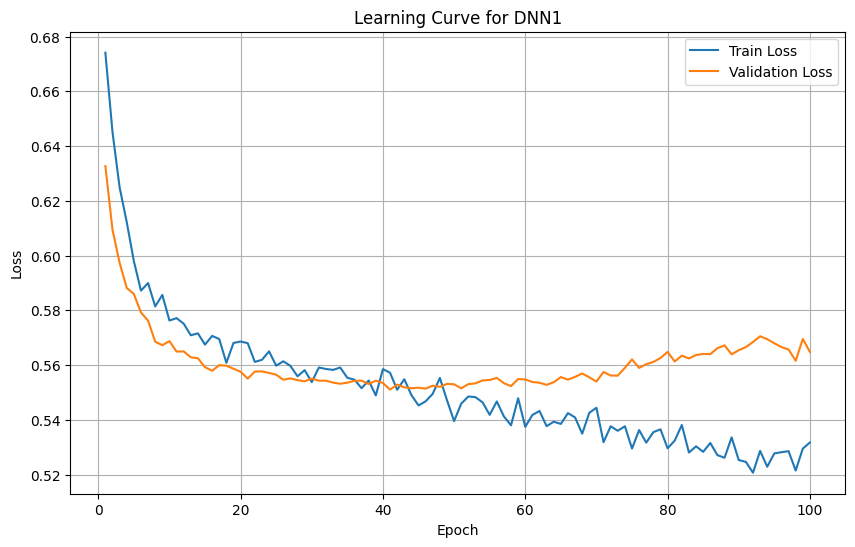

In [36]:
best_params=study.best_params
model = DNN_2(input_dim=X_train_tensor.shape[1],
              hidden_units1=best_params["hidden_units1"],
              hidden_units2=best_params["hidden_units2"],
              hidden_units3=best_params["hidden_units3"],
              hidden_units4=best_params["hidden_units4"],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              dropout3=best_params["dropout3"],
              dropout4=best_params["dropout4"]).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 58.77%
Precision: 0.4710
Recall: 0.5516
F1 Score: 0.5082
Matthews Correlation Coefficient: 0.1585
Specificity: 0.6104


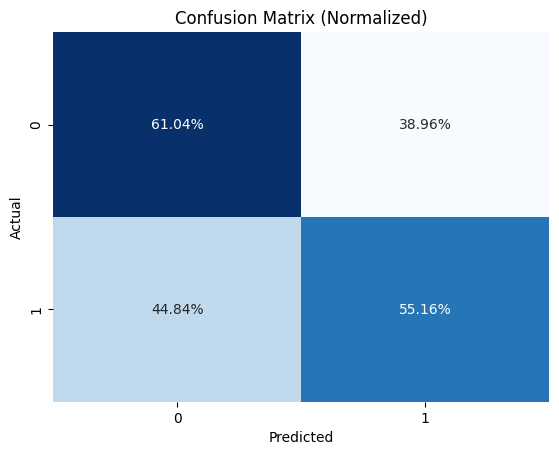

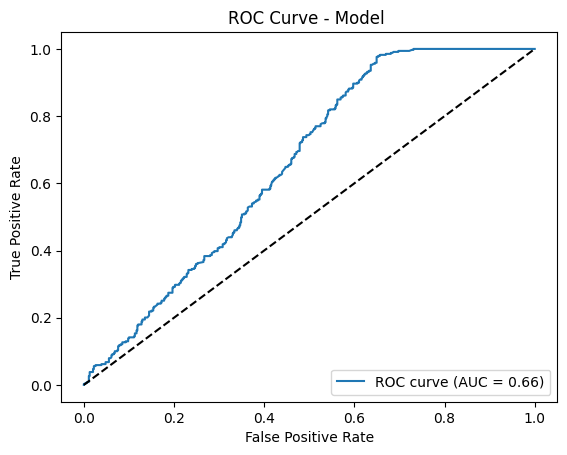

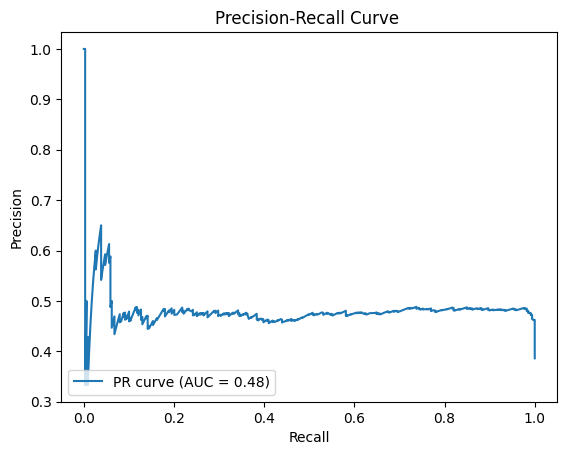

In [37]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs > 0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [38]:
# モデルと構造を保存
torch.save(model, '../../saved_model/DNN_2.pth')
